In [315]:
!pip install pmdarima
!pip install prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import pickle
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from scipy.stats import jarque_bera

In [316]:
dfo = pd.read_csv("AEP_hourly.csv")

In [317]:
dfo.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [318]:
dfo["Datetime"] = pd.to_datetime(dfo["Datetime"])

In [319]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='D')).sum()

# Agregacja dzienna

In [320]:
df.sort_index(inplace = True)

In [321]:
df = df.iloc[:-1] # Ostatni dzień jest niepełny, odrzucamy go, aby nie zaburzał nam wykresów

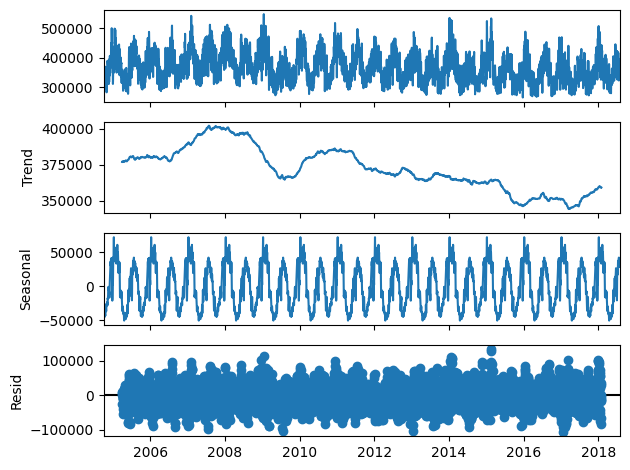

In [322]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 365)
decomp_a.plot()
plt.show()

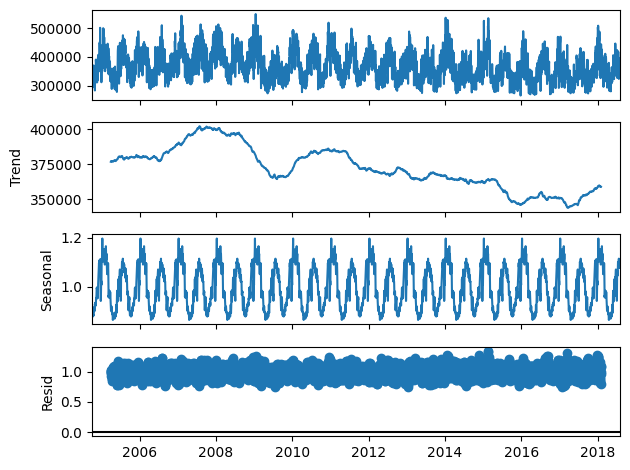

In [323]:
decomp_am = seasonal_decompose(df, model = 'multiplicative', period = 365)
decomp_am.plot()
plt.show()

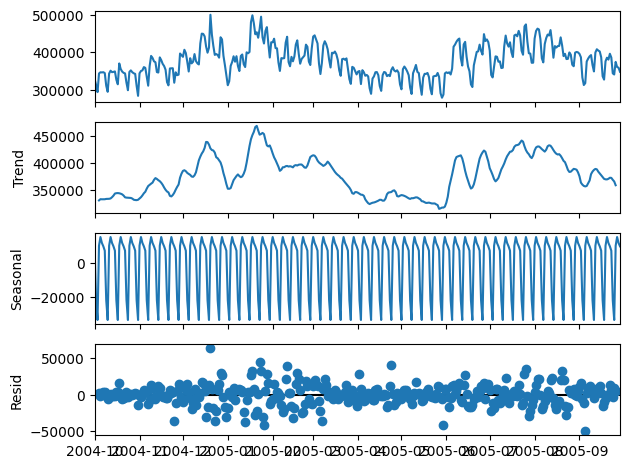

In [324]:
decomp_b = seasonal_decompose(df[:364], model = 'additive', period = 7)
decomp_b.plot()
plt.show()

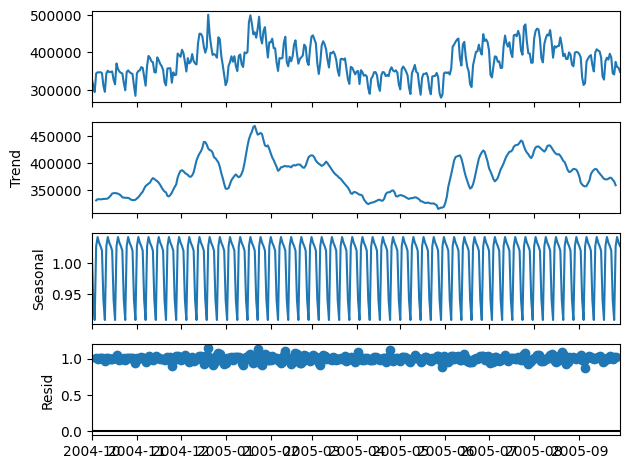

In [325]:
decomp_bm = seasonal_decompose(df[:364], model = 'multiplicative', period = 7)
decomp_bm.plot()
plt.show()

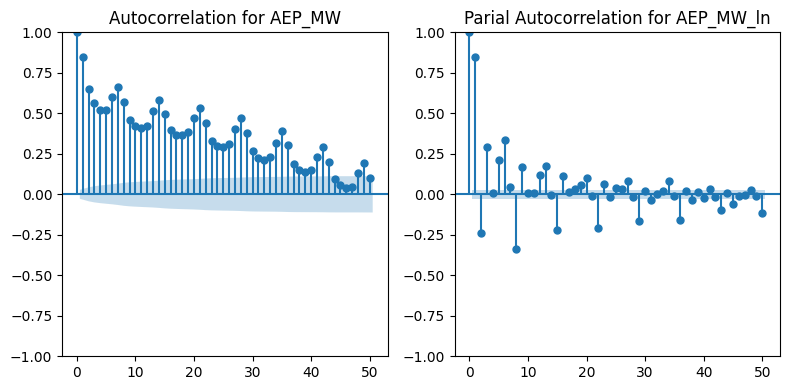

In [326]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=50, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

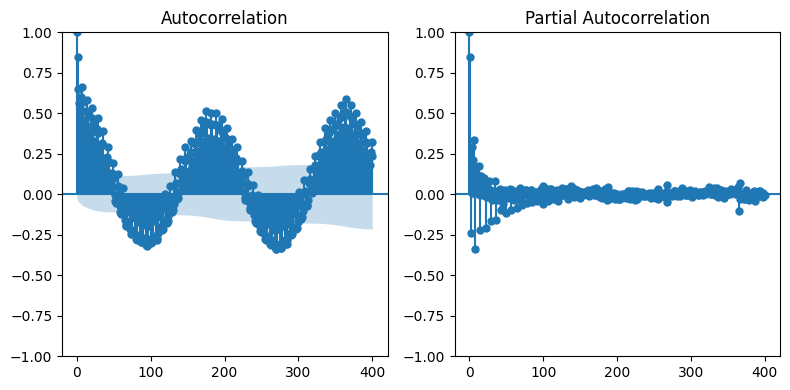

In [327]:
fig2, axes2 = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=400, ax=axes2[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=400, ax=axes2[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Po zagregowaniu danych według dnia widać, że w danych występują dwie osobne sezonowości: sezonowość tygodniowa oraz sezonowość roczna. Podobnie jak w przypadku agregacji tygodniowej, wartość cząstkowej autokorelacji jest największa przy pierwszym opóźnieniu.

W następnej fazie spróbujemy dokonać dekompozycji tego szeregu ręcznie. Dokonamy tego na dwa sposoby - raz, szukając sezonowości tygodniowej, a drugi raz, szukając sezonowości rocznej.

In [328]:
df.head()

,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


In [329]:
df.tail()

,AEP_MW
Datetime,
2018-07-29,327792.0
2018-07-30,368834.0
2018-07-31,364327.0
2018-08-01,363628.0
2018-08-02,376504.0


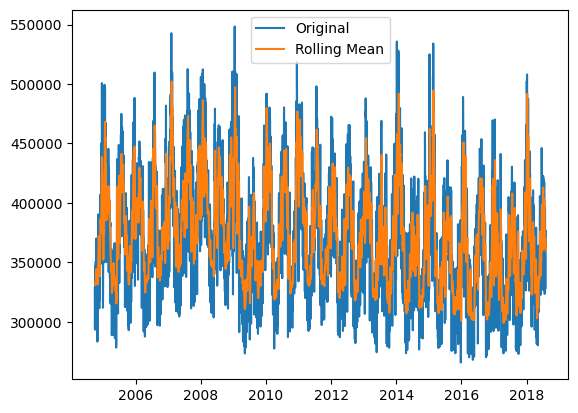

In [330]:
df_ma7 = df.rolling(window = 7).mean()
plt.plot(df, label = 'Original')
plt.plot(df_ma7, label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

Poniżej możemy porównać kilka różnych lat z badanego okresu po zastosowaniu uśrednienia na tygodniach. Na wykresie wyraźnie widać sezonowość na przestrzeni roku - zużycie energii jest zdecydowanie największe w zimie i w lecie, a mniejsze na wiosnę i na jesień.

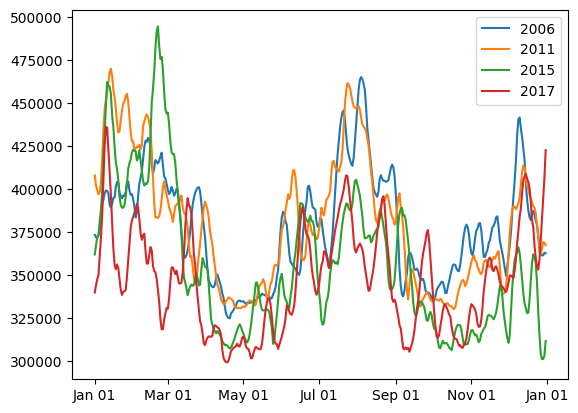

In [331]:
years = ["2006", "2011", "2015", "2017"]
for year in years:
    dfl = df_ma7.loc[year]
    plt.plot(pd.to_datetime(dfl.index.dayofyear, format='%j', yearfirst=True), dfl, label = year)
plt.legend(loc = 'best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

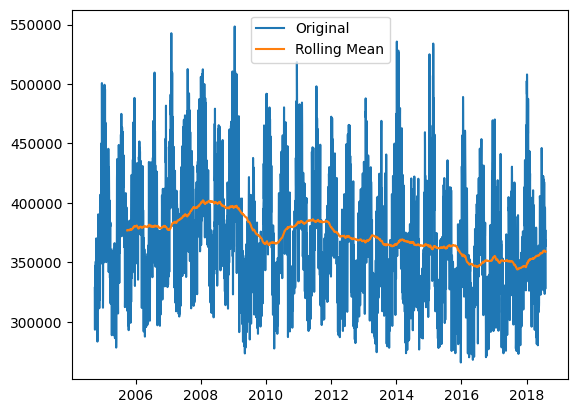

In [332]:
df_ma365 = df.rolling(window = 365).mean()
plt.plot(df, label = 'Original')
plt.plot(df_ma365, label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.show()

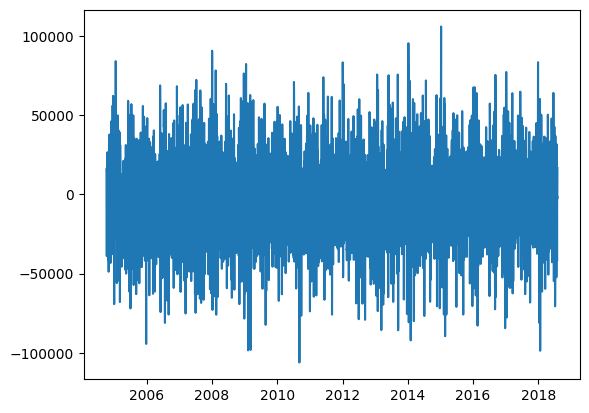

In [333]:
df_no7trend = df - df_ma7
df_no7trend.dropna(inplace = True)
plt.plot(df_no7trend)
plt.show()

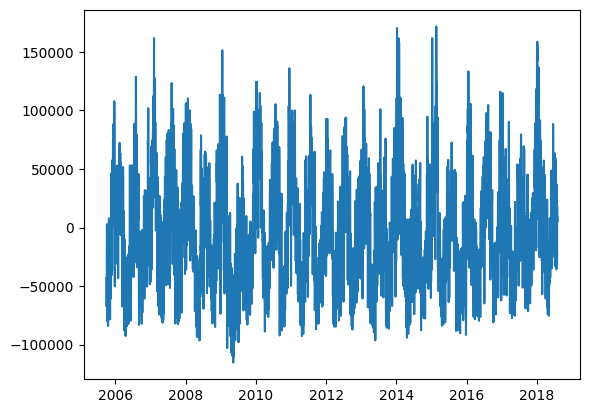

In [334]:
df_no365trend = df - df_ma365
df_no365trend.dropna(inplace = True)
plt.plot(df_no365trend)
plt.show()

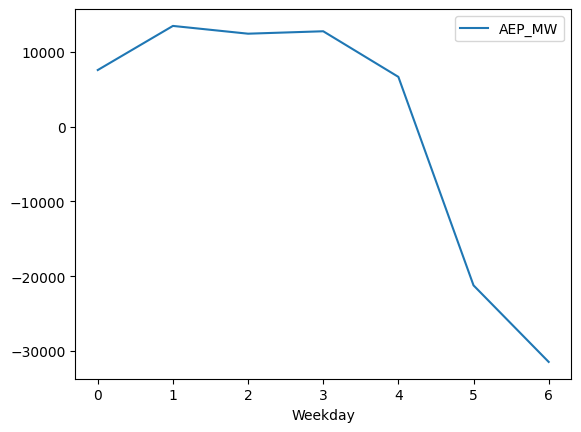

In [335]:
df_no7trend['Weekday'] = df_no7trend.index.weekday
weekly_avg = df_no7trend.groupby('Weekday').mean()
weekly_avg.plot()
plt.show()

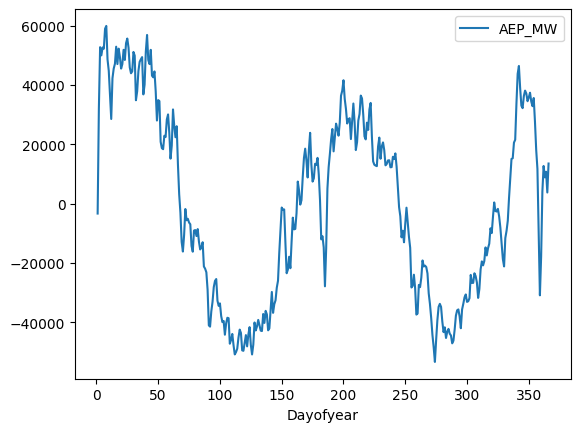

In [336]:
df_no365trend['Dayofyear'] = df_no365trend.index.dayofyear
yearly_avg = df_no365trend.groupby('Dayofyear').mean()
yearly_avg.plot()
plt.show()

In [337]:
weekly_avg

,AEP_MW
Weekday,
0,7554.605508
1,13452.078264
2,12413.306519
3,12738.256035
4,6640.297206
5,-21229.777293
6,-31463.829998


In [338]:
df_no7trend = pd.merge(df_no7trend, weekly_avg, how = 'left', left_on = 'Weekday', right_index = True)

In [339]:
df_no7trend.rename(columns = {'AEP_MW_x':'AEP_MW', 'AEP_MW_y':'Weekly_Avg'}, inplace = True)

In [340]:
df_no7trend.head(n = 14)

,AEP_MW,Weekday,Weekly_Avg
Datetime,,,
2004-10-07,15794.285714,3,12738.256035
2004-10-08,11150.000000,4,6640.297206
2004-10-09,-22605.000000,5,-21229.777293
2004-10-10,-38899.142857,6,-31463.829998
2004-10-11,10077.714286,0,7554.605508
2004-10-12,17041.000000,1,13452.078264
2004-10-13,13087.428571,2,12413.306519
2004-10-14,13678.857143,3,12738.256035
2004-10-15,14304.857143,4,6640.297206


In [341]:
df_no365trend = pd.merge(df_no365trend, yearly_avg, how = 'left', left_on = 'Dayofyear', right_index = True)

In [342]:
df_no365trend.rename(columns = {'AEP_MW_x':'AEP_MW', 'AEP_MW_y':'Yearly_Avg'}, inplace = True)

In [343]:
df_no365trend.head(10)

,AEP_MW,Dayofyear,Yearly_Avg
Datetime,,,
2005-09-30,-43213.879452,273,-48299.245100
2005-10-01,-67543.035616,274,-53310.624025
2005-10-02,-61842.167123,275,-45938.874605
2005-10-03,-1113.112329,276,-39279.298630
2005-10-04,2800.841096,277,-34776.893361
2005-10-05,493.473973,278,-33746.890832
2005-10-06,-607.087671,279,-34779.327503
2005-10-07,-26139.112329,280,-39676.734668
2005-10-08,-63807.219178,281,-43276.831823


In [344]:
df_no7trend['Noise'] = df_no7trend['AEP_MW'] - df_no7trend['Weekly_Avg']
df_no365trend['Noise'] = df_no365trend['AEP_MW'] - df_no365trend['Yearly_Avg']

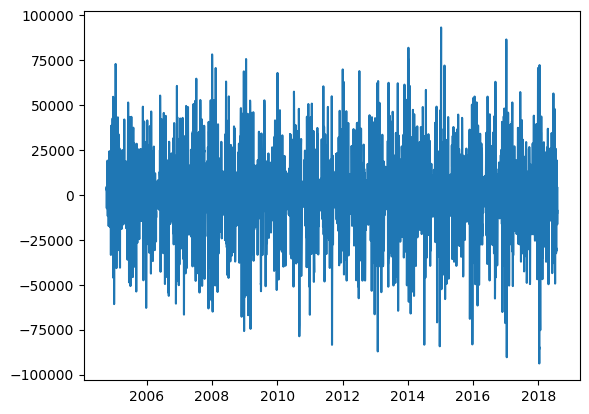

In [345]:
plt.plot(df_no7trend['Noise'])
plt.show()

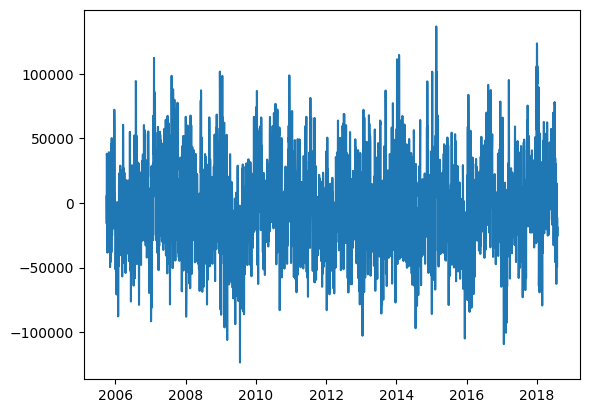

In [346]:
plt.plot(df_no365trend['Noise'])
plt.show()

Możemy zauważyć, że po usunięciu z danych sezonowości tygodniowej nadal widoczna jest sezonowość roczna i vice versa. Niestety wyciągnięcie obu tych sezonowości naraz wydaje się trudne, ponieważ się na siebie nakładają, i zwykłe odjęcie obu sezonowości zaburzyłoby nam poprawną interpretację komponentu "noise".

W dalszym ciągu dokonujemy analizy podobnej do tej, którą stosowaliśmy przy agregacji tygodniowej. Dokonamy zróżnicowania co 7 i co 365 dni, aby usunąć trend na przestrzeni tygodnia i roku, dodatkowo będziemy też badać logarytmy naszych danych. Będziemy próbowali dopasować modele do danych oraz zobaczymy, co się stanie, jeśli będziemy próbowali dopasować model wyłącznie do sezonowości tygodniowej bez uwzględnienia sezonowości rocznej.

In [347]:
df['AEP_MW_ln'] = np.log(df['AEP_MW'])

In [348]:
dfd = df.diff(7).diff(365)
dfd = dfd.dropna()

In [349]:
dfd.head()

,AEP_MW,AEP_MW_ln
Datetime,,
2005-10-08,-11698.0,-0.033775
2005-10-09,-16337.0,-0.053489
2005-10-10,-34710.0,-0.097258
2005-10-11,-32950.0,-0.090712
2005-10-12,-34679.0,-0.096182


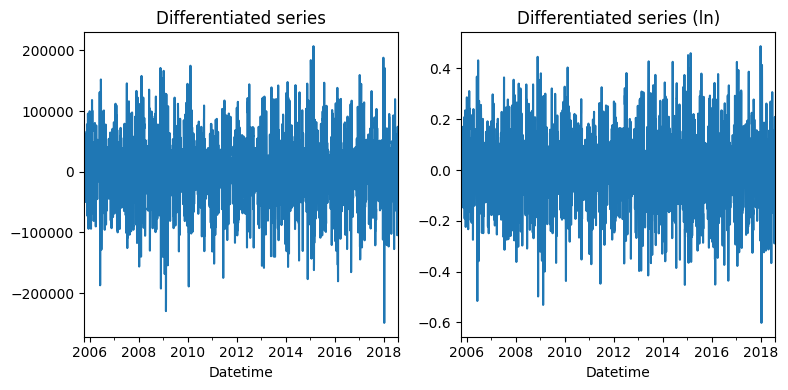

In [350]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0])
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

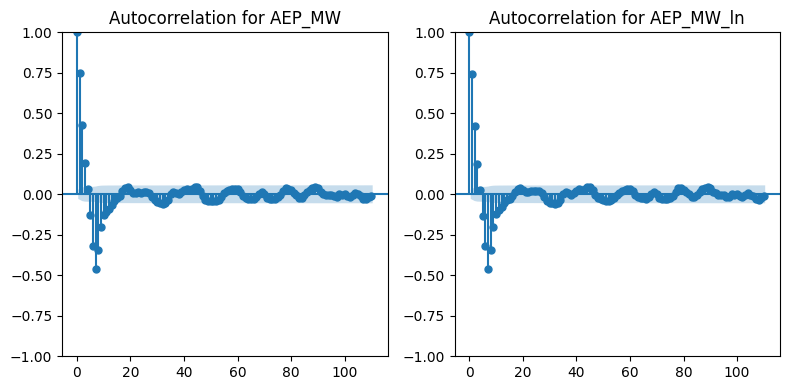

In [351]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

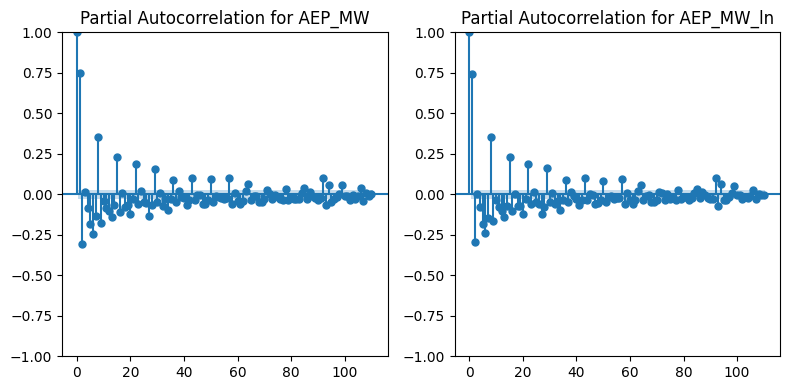

In [352]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

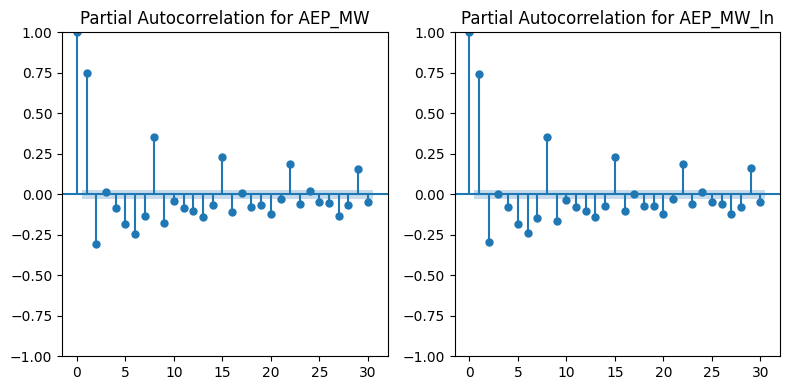

In [353]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=30, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Można zaobserwować, że funkcja PACF mocno się wybija dla n = 7k + 1. Podejrzewam, że ma to związek albo z latami przestępnymi, albo z faktem, że 365 daje resztę 1 z dzielenia przez 7 (co oznacza, że jak zrobimy diff(365) to dni tygodnia z kolejnych lat będą przesunięte względem siebie o 1).

In [354]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-wartość dla pierwotnego szeregu po zróżnicowaniu to {adt1[1]}, a p-wartość dla logarytmu tego szeregu i zróżnicowaniu to {adt2[1]}")
print("Tak zróżnicowane szeregi są stacjonarne.")

p-wartość dla pierwotnego szeregu po zróżnicowaniu to 7.091863711796819e-30, a p-wartość dla logarytmu tego szeregu i zróżnicowaniu to 7.659768939135218e-30
Tak zróżnicowane szeregi są stacjonarne.


Dostajemy potwierdzenie, że po zróżnicowaniu możemy traktować szeregi jako stacjonarne.

W następnym kroku spróbujemy dopasować model SARIMA do szeregu zagregowanego po dniu. Niestety, dopasowanie do okresu 365 dni (rok) nie jest możliwe dla mocy obliczeniowej, którą dysponujemy. Daje nam to jednak ciekawą okazję do tego, aby dopasować model do sezonowości tygodniowej, ignorując sezonowość roczną i zobaczyć, jaki będzie efekt.

In [355]:
combinations = list(itertools.product([0, 1, 2], repeat=4))
matrix = np.array(combinations)
dfL = pd.DataFrame(matrix, columns = ['p', 'q', 'P', 'Q'])
dfL.drop(0, inplace = True)
dfL['AIC'] = 0
dfL['BIC'] = 0

dfL2 = dfL.copy()

In [356]:
data_train = df.loc['2005-01-01':'2017-12-31', :]
data_test = df.loc['2018-01-01':'2018-06-30', :]

In [357]:
# for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 7))
#     model = model.fit()
#     dfL.loc[i, 'AIC'] = model.aic
#     dfL.loc[i, 'BIC'] = model.bic
# for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 7))
#     model = model.fit()
#     dfL2.loc[i, 'AIC'] = model.aic
#     dfL2.loc[i, 'BIC'] = model.bic

# dfL.to_pickle("dfL.pkl")
# dfL2.to_pickle("dfL2.pkl")

In [358]:
# for i in tqdm(dfL.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW'], order = (dfL.loc[i, 'p'], 1, dfL.loc[i, 'q']), seasonal_order = (dfL.loc[i, 'P'], 1, dfL.loc[i, 'Q'], 365))
#     model = model.fit()
#     dfL.loc[i, 'AIC'] = model.aic
#     dfL.loc[i, 'BIC'] = model.bic
# for i in tqdm(dfL2.index, desc="Przetwarzanie SARIMA dla dfL"):
#     model = SARIMAX(data_train['AEP_MW_ln'], order = (dfL2.loc[i, 'p'], 1, dfL2.loc[i, 'q']), seasonal_order = (dfL2.loc[i, 'P'], 1, dfL2.loc[i, 'Q'], 365))
#     model = model.fit()
#     dfL2.loc[i, 'AIC'] = model.aic
#     dfL2.loc[i, 'BIC'] = model.bic

# dfL.to_pickle("dfL3.pkl")
# dfL2.to_pickle("dfL4.pkl")

# Niestety wyliczenie SARIMA dla okresu 365 dni zdecydowanie przekracza możliwości obliczeniowe

In [359]:
dfL = pd.read_pickle("dfL.pkl")
dfL2 = pd.read_pickle("dfL2.pkl")

In [360]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])

df_IC.reset_index(drop = True, inplace= True)
df_IC

,p,q,P,Q,AIC,BIC
0,2,1,0,1,105930.241197,105962.560159
1,2,1,0,1,105930.241197,105962.560159
2,2,2,1,2,106844.254360,106895.964699
3,2,2,1,2,106844.254360,106895.964699


Tym razem otrzymujemy zupełnie inne modele niż te, które dostaliśmy przy agregacji tygodniowej. Niewątpliwie wynika to z faktu, że dopasowujemy go do innej sezonowości. Przekonamy się jeszcze, jak dobrze te modele odpowiadają rzeczywistości.

In [361]:
models = []
for i in range(3):
    if i < 2:
        model = SARIMAX(data_train['AEP_MW'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 7))
    else:
        model = SARIMAX(data_train['AEP_MW_ln'], order = (df_IC.loc[i, 'p'], 1, df_IC.loc[i, 'q']), seasonal_order = (df_IC.loc[i, 'P'], 1, df_IC.loc[i, 'Q'], 7))
    models.append(model.fit())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model nr 0


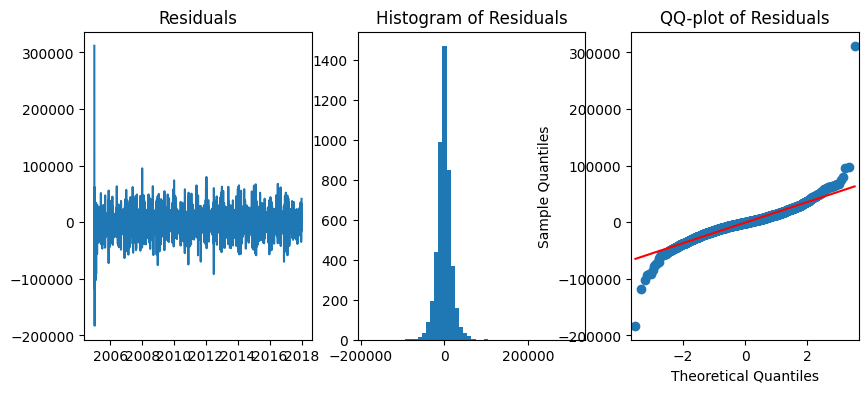

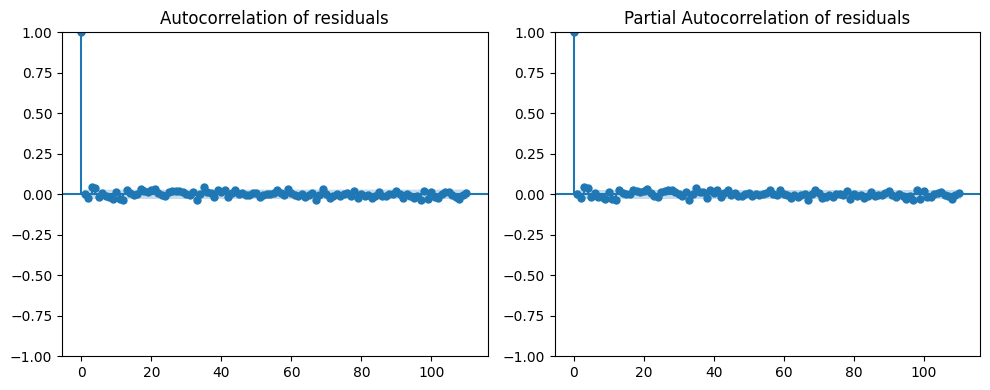

Model nr 1


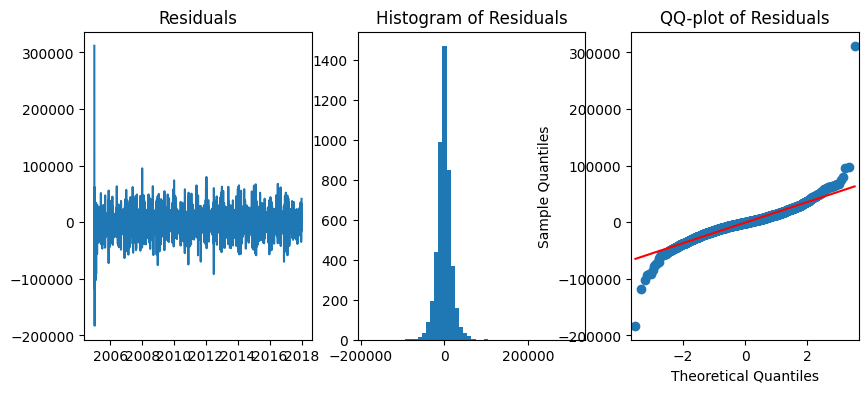

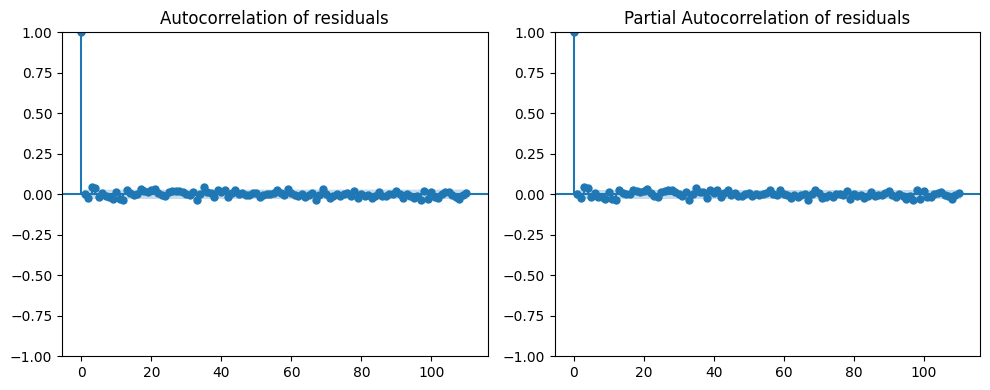

Model nr 2


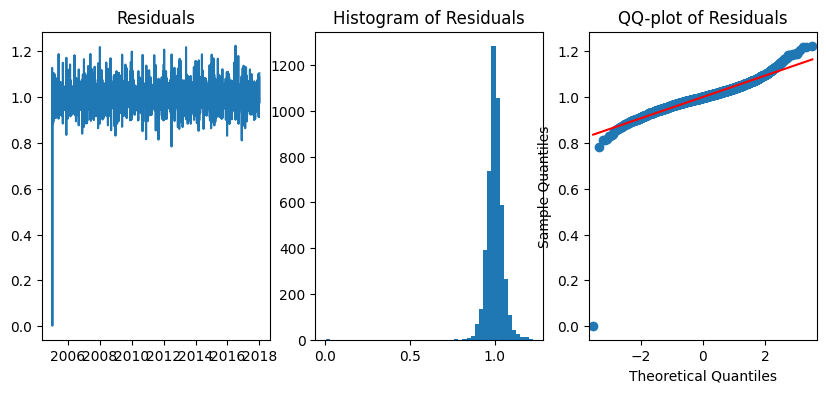

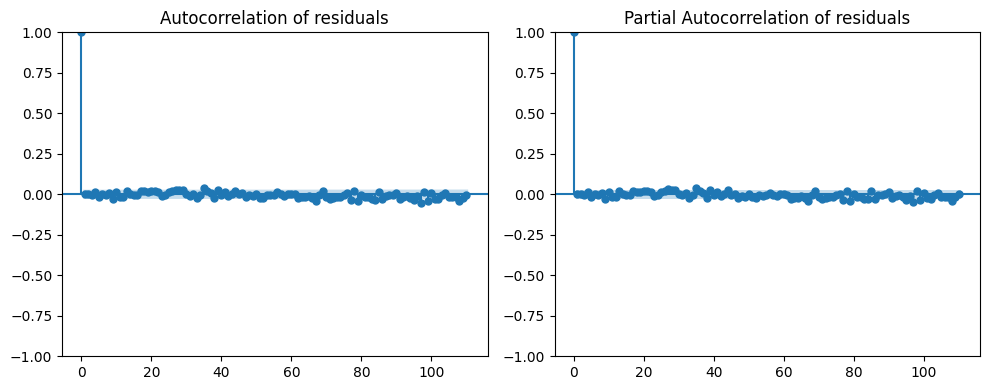

In [362]:
resid_list = []

for i in range(3):

    print(f'Model nr {i}')
    model_fit = models[i]

    if i < 2:
        resid = model_fit.resid
    else:
        resid = np.exp(model_fit.resid[1:])

    resid_list.append(resid)

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")

    plt.tight_layout()
    plt.show()

In [363]:
model_names = ['SARIMA(2,1,1,0,1,1,7)', 'SARIMA(2,1,1,0,1,1,7)', 'SARIMA(2,1,2,1,1,2,7)']

In [364]:
for i in range(3):
    resid = resid_list[i]
    stap, p = shapiro(resid)
    p2 = jarque_bera(resid)
    print(f'P value testu SW dla modelu {model_names[i]} wynosi {p} \n')
    print(f'P value testu JB dla modelu {model_names[i]} wynosi {p2[1]} \n')

P value testu SW dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 1.2969208958145409e-44 

P value testu JB dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 0.0 

P value testu SW dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 1.2969208958145409e-44 

P value testu JB dla modelu SARIMA(2,1,1,0,1,1,7) wynosi 0.0 

P value testu SW dla modelu SARIMA(2,1,2,1,1,2,7) wynosi 4.000063944339407e-46 

P value testu JB dla modelu SARIMA(2,1,2,1,1,2,7) wynosi 0.0 



Chociaż ponownie reszty na wykresach wyglądają na pochodzące z rozkładu normalnego, to testy statystyczne twierdzą, że tak nie jest. W tym przypadku prawdopodobnym czynnikiem wpływającym na to jest fakt, że modele są dopasowane do sezonowości tygodniowej, ale nie uwzględniają sezonowości rocznej, która ma nadal wpływ na to, jak wyglądają reszty.

In [365]:
df_pred = data_test[['AEP_MW']].copy()

In [366]:
for i in range(3):
    model_fit = models[i]
    pred = model_fit.predict(start = '2018-01-07', end = '2018-06-24')
    if i < 2:
        df_pred[f'Pred no {i}'] = pred
    else:
        df_pred[f'Pred no {i}'] = np.exp(pred)

In [367]:
dfp1 = data_train[['AEP_MW']].copy()
dfp2 = data_train[['AEP_MW_ln']].copy()
dfp1.reset_index(inplace = True)
dfp2.reset_index(inplace = True)
dfp1.columns = ['ds', 'y']
dfp2.columns = ['ds', 'y']

In [368]:
modelp1 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)
modelp2 = Prophet(yearly_seasonality = False, weekly_seasonality = False, daily_seasonality = False)

In [369]:
modelp1.add_seasonality(name='yearly', period=365, fourier_order=5)
modelp1.add_seasonality(name='weekly', period=7, fourier_order=3)

modelp2.add_seasonality(name='yearly', period=365, fourier_order=5)
modelp2.add_seasonality(name='weekly', period=7, fourier_order=3)

In [370]:
modelp_fit1 = modelp1.fit(dfp1)
modelp_fit2 = modelp2.fit(dfp2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/q8grfymh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/k8x974e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22988', 'data', 'file=/tmp/tmp96hd8b9f/q8grfymh.json', 'init=/tmp/tmp96hd8b9f/k8x974e1.json', 'output', 'file=/tmp/tmp96hd8b9f/prophet_model6xzmtorb/prophet_model-20250131220340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:03:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/7o_1y_f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96hd8b9f/0asbyvp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [371]:
future = modelp_fit1.make_future_dataframe(periods=185, freq = 'D')

In [372]:
predp1 = modelp_fit1.predict(future)[['ds', 'yhat']]
predp2 = modelp_fit2.predict(future)[['ds', 'yhat']]

In [373]:
df_pred = df_pred.merge(predp1.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 3'}, axis =1, inplace = True)

In [374]:
df_pred = df_pred.merge(predp2.set_index('ds'), left_index = True, right_index = True)
df_pred.rename({'yhat':'Pred no 4'}, axis =1, inplace = True)

In [375]:
df_pred['Pred no 4'] = np.exp(df_pred['Pred no 4'])

In [376]:
df_ts = data_train.copy()

In [377]:
vals_x = np.arange(len(df_ts))
vals_y1 = df_ts[['AEP_MW']].values
vals_y2 = df_ts[['AEP_MW_ln']].values

In [378]:
poly = PolynomialFeatures(degree=3)
vals_x_poly = poly.fit_transform(vals_x.reshape(-1, 1))

In [379]:
model_poly1 = LinearRegression().fit(vals_x_poly, vals_y1)
model_poly2 = LinearRegression().fit(vals_x_poly, vals_y2)

In [380]:
df_ts['Trend'] = model_poly1.predict(vals_x_poly)
df_ts['Trend_ln'] = model_poly2.predict(vals_x_poly)

In [381]:
df_ts['Detrend'] = df_ts['AEP_MW'] - df_ts['Trend']
df_ts['Detrend_ln'] = df_ts['AEP_MW_ln'] - df_ts['Trend_ln']

In [382]:
df_ts = df_ts.loc[df_ts['Trend'].notna(), :]
df_ts = df_ts.loc[df_ts.index.year > 2004]

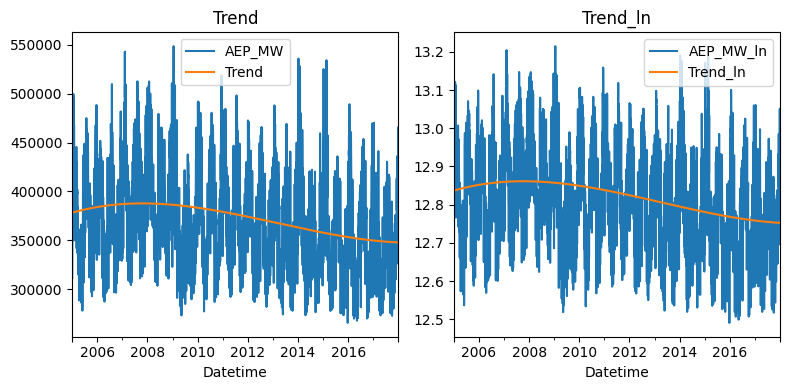

In [383]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend_ln")

plt.tight_layout()
plt.show()

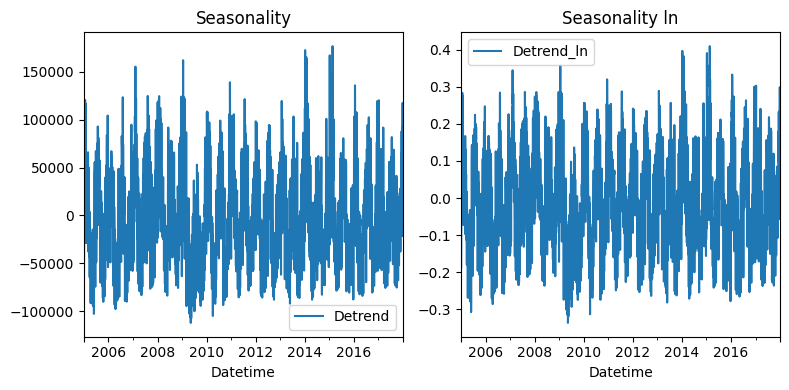

In [384]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

In [385]:
df_ts['Day no'] = np.nan
curr_year = df_ts.index[0].year
i = 1
for j in df_ts.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts.loc[j, 'Day no'] = i
        curr_year = next_year
    else:
        df_ts.loc[j, 'Day no'] = i
        i = i + 1

In [386]:
df_ts = df_ts.reset_index().merge(df_ts[['Day no', 'Detrend', 'Detrend_ln']].reset_index(drop = True).groupby('Day no').mean().rename({'Detrend':'Seasonality', 'Detrend_ln':'Seasonality_ln'}, axis = 1), left_on = 'Day no', right_on = 'Day no')

df_ts = df_ts.set_index('Datetime').sort_index()

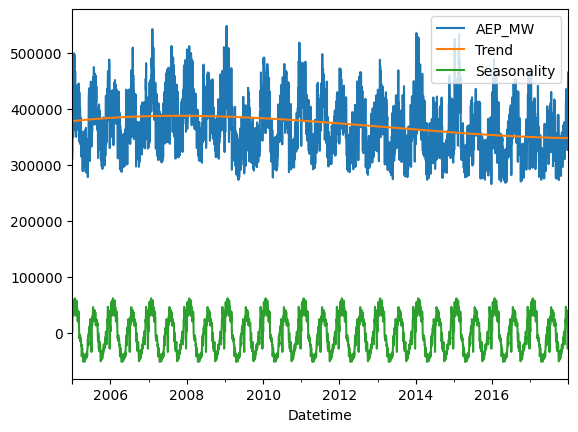

In [387]:
df_ts[['AEP_MW', 'Trend', 'Seasonality']].plot()
plt.show()

In [388]:
df_ts_pred = data_test.copy()
df_ts_pred['Day no'] = np.nan
curr_year = df_ts_pred.index[0].year
i = 1
for j in df_ts_pred.index:
    #print(j)
    next_year = j.year
    if curr_year < next_year:
        i = 1
        df_ts_pred.loc[j, 'Day no'] = i
        curr_year = next_year
    else:
        df_ts_pred.loc[j, 'Day no'] = i
        i = i + 1

In [389]:
df_ts_pred = df_ts_pred.reset_index().merge(df_ts[['Day no', 'Seasonality', 'Seasonality_ln']].head(181), left_on = 'Day no', right_on = 'Day no', how = 'left')

vals_x_p = np.arange(vals_x[-1] + 1, vals_x[-1] + 182)

In [390]:
vals_x_poly_p = poly.fit_transform(vals_x_p.reshape(-1, 1))

In [391]:
df_ts_pred['Trend'] = model_poly1.predict(vals_x_poly_p)
df_ts_pred['Trend_ln'] = model_poly2.predict(vals_x_poly_p)

In [392]:
df_ts_pred['Pred'] = df_ts_pred['Trend'] + df_ts_pred['Seasonality']
df_ts_pred['Pred_ln'] = df_ts_pred['Trend_ln'] + df_ts_pred['Seasonality_ln']

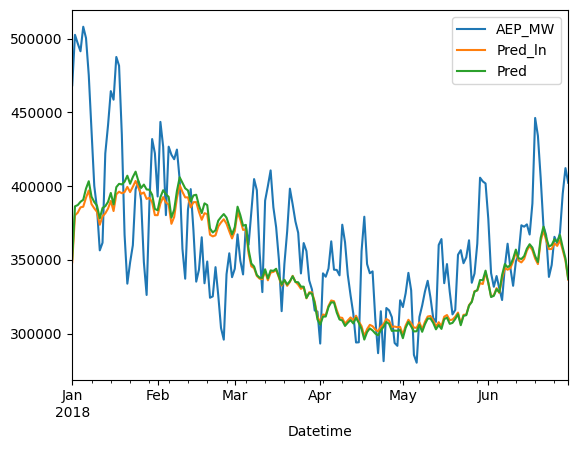

In [393]:
df_ts_pred.set_index('Datetime', inplace =  True)
df_ts_pred['Pred_ln'] = np.exp(df_ts_pred['Pred_ln'])
df_ts_pred[['AEP_MW','Pred_ln', 'Pred']].plot()
plt.show()

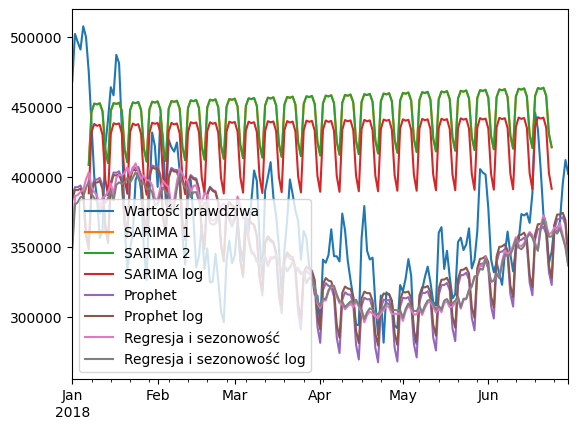

In [394]:
df_ts_pred.rename({'Pred':'Pred no 5', 'Pred_ln':'Pred no 6'}, axis = 1, inplace = True)
df_pred = df_pred.merge(df_ts_pred[['Pred no 5', 'Pred no 6']], left_index = True, right_index = True)

df_pred.columns = ['Wartość prawdziwa', 'SARIMA 1', 'SARIMA 2', 'SARIMA log', 'Prophet', 'Prophet log', 'Regresja i sezonowość', 'Regresja i sezonowość log']

df_pred.plot()
plt.show()

Jak widać na wykresie, SARIMA zbudowana na okresie 7 dni nie jest odpowiednim modelem do przewidywania potrzebnej energii - ignoruje ona kompletnie sezonowość roczną i uwzględnia tylko (niewiele znaczący) trend, a tak się składa, że w naszych danych sezonowość roczna wyraźnie dominuje nad sezonowością tygodniową pod względem amplitudy. Można się zastanawiać, jak SARIMA by sobie poradziła, gdyby była zbudowana na okresie 365 dni - pewne porównanie mamy w przypadku agregacji tygodniowej, ale w przypadku agregacji dziennej brakuje mocy obliczeniowej, aby zbudować odpowiedni model.

Pozostałe modele uwzględniają sezonowość roczną razem z sezonowością tygodniową i dużo lepiej dopasowują się do rzeczywistych wartości. Można zauważyć, że model zbudowany przez Propheta bardzo ściśle przestrzega sezonowości tygodniowej, a model powstały z regresji jest dużo bardziej uśredniony. Możemy porównać błędy tych modeli, aby się przekonać, które z nich są faktycznie lepsze.

Błędy będziemy liczyć z takich samych wzorów, jak przy agregacji tygodniowej.

In [400]:
for i in range(1,8):
    err = df_pred['Wartość prawdziwa'] - df_pred[df_pred.columns[i]]
    df_pred[f'Err no {i}'] = err
df_err = pd.DataFrame(index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7'],columns = ['L2', 'L3', 'AL2', 'AL3'])

LP2 = ((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**2).sum(axis = 0))**(1/2)
LP3 = (np.abs(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]**3).sum(axis = 0))**(1/3)
ALP2 = (((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**2).sum(axis = 0))**(1/2)
ALP3 = (np.abs((df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']]*np.where(df_pred[['Err no 1', 'Err no 2', 'Err no 3', 'Err no 4', 'Err no 5', 'Err no 6', 'Err no 7']] < 0, 1.1, 0.9))**3).sum(axis = 0))**(1/3)

df_err.loc[:, 'L2'] = LP2.values
df_err.loc[:, 'L3'] = LP3.values
df_err.loc[:, 'AL2'] = ALP2.values
df_err.loc[:, 'AL3'] = ALP3.values

15

In [397]:
df_err

,L2,L3,AL2,AL3
Model 1,1246351.453808,557871.907303,1369846.218961,613447.056411
Model 2,1246351.453808,557871.907303,1369846.218961,613447.056411
Model 3,1008992.698572,458056.846917,1106647.884185,502988.458064
Model 4,554443.297601,279824.634702,517397.981444,258737.572416
Model 5,534859.735179,276841.217871,499566.706673,255761.899421
Model 6,568106.476817,282009.492004,537048.584021,264818.903379
Model 7,570896.023522,286388.112051,535074.180548,266034.86343


Według obliczonych błędów model Propheta jest minimalnie lepszy niż model regresji liniowej, a oba są dużo lepsze niż modele SARIMA z okresem 7. Modele te mają też wyraźnie mniejszy błąd niż modele w agregacji tygodniowej - co prawdopodobnie wynika z większej dokładności, z jaką mogliśmy zbudować te modele, dzięki czemu lepiej uchwyciliśmy sezonowości, którym te dane podlegają.